# Data Workflows Hands-on Exercises 

This notebook showcases the functionalities offered by the Cognite Data Fusion Data Workflows. In this notebook, we will create some dummy Functions, TimeSeries, and Transformations for use in the rest of the notebook exercises. 

The project we will be using for this course is in a training environment, and it will be used by other learners from the course. For that, please make sure to use "FirstnameBirthyear" (example, madina1997) prefix to differentiate the workflows and tasks you are creating. Which means you need to replace FirstnameBirthyear with your unique name and birthyear whenever FirstnameBirthyear naming convention is mentioned.

## Authentication and Client Creation

Here we'll create the Cognite client using an interactive flow. Once this client is created, this will be the main way to communicate with the Cognite Data Fusion.

Import and create a client to communicate with the Cognite Data Fusion (CDF).

In [ ]:
%pip install cognite_sdk networkx matplotlib pandas

In [ ]:
from cognite.client import CogniteClient, ClientConfig
from cognite.client.credentials import Token
from msal import PublicClientApplication

TENANT_ID = "48d5043c-cf70-4c49-881c-c638f5796997"
CLIENT_ID = "7c830d37-1bdd-43a5-80ee-d842a712a919"
CDF_CLUSTER = "westeurope-1"
COGNITE_PROJECT = "learn"

SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]
TOKEN_URL = f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/v2.0/token"
AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000


def authenticate_azure():

    app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)

    # interactive login - make sure you have http://localhost:port in Redirect URI in App Registration as type "Mobile and desktop applications"
    creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)
    return creds


creds = authenticate_azure()

cnf = ClientConfig(
    client_name="workflow_FirstnameBirthyear_client",
    project=COGNITE_PROJECT,
    credentials=Token(creds["access_token"]),
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
)
client = CogniteClient(cnf)

workflows = client.workflows

workflows.list()

The next few cells will set up some helpers for the rest of the notebook and populate some dummy Functions, TimeSeries, and Transformations for use in the rest of the notebook exercises. These will be cleaned up at the end of the notebook (see the last section). Make sure to run all the set up cells until the "Workflow Concepts" section. 

In [ ]:
from cognite.client.data_classes import WorkflowVersion
import networkx as nx
import matplotlib.pyplot as plt

def visualize_workflow_version(workflow_version: WorkflowVersion):
    # Extract tasks and their dependencies from the workflow_version_upsert object
    tasks = workflow_version.workflow_definition.tasks

    task_dict = {}
    for task in tasks:
        task_dict[task.external_id] = task.depends_on or []

    # Add start and end nodes
    start_tasks = [task for task, deps in task_dict.items() if not deps]
    end_tasks = [task for task, deps in task_dict.items() if not any(task in dep for dep in task_dict.values())]

    # Create the graph
    G = nx.DiGraph()
    G.add_node("start")
    G.add_node("end")

    for task, deps in task_dict.items():
        if not deps:
            G.add_edge("start", task)
        for dep in deps:
            G.add_edge(dep, task)
        if task in end_tasks:
            G.add_edge(task, "end")

    # Define positions for the nodes in the graph
    pos = {}
    layer_width = 1
    layer_height = 1
    current_y = 0

    pos["start"] = (0, 0)
    current_x = layer_width

    for task in start_tasks:
        pos[task] = (current_x, current_y)
        current_y -= layer_height

    for task, deps in task_dict.items():
        if deps:
            current_x += layer_width
            for dep in deps:
                if dep in pos:
                    dep_y = pos[dep][1]
                    pos[task] = (current_x, dep_y)
                    current_y = dep_y - layer_height
                else:
                    pos[task] = (current_x, current_y)
                    current_y -= layer_height

    current_y = 0
    current_x += layer_width
    for task in end_tasks:
        pos[task] = (current_x, current_y)
        current_y -= layer_height

    pos["end"] = (current_x + layer_width, 0)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')

    # Draw the edges
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray')

    # Draw the labels
    labels = {task: task for task in G.nodes}
    labels["start"] = "Start"
    labels["end"] = "End"
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    # Display the graph
    plt.title("Workflow Task Graph")
    plt.axis('off')  # Turn off the axis
    plt.show()

In [5]:
def show_execution_progress(execution_id: int):
    execution = workflows.executions.retrieve_detailed(id=execution_id)
    print(f"Execution status: {execution.status}")
    if execution.reason_for_incompletion:
        print(f"Execution reason for incompletion: {execution.reason_for_incompletion}")
    print("Executed tasks:")
    for task in execution.executed_tasks:
        print(task.dump())
        print("")

In [ ]:
def handle(client, data):
    prefix = data["timeseries-prefix"]
    print(f"fetching timeseries with prefix: {prefix}")
    ts = client.time_series.list(external_id_prefix=prefix)
    print(f"time series results: {ts}")
    ts_ext_ids = [ts.external_id for ts in ts]
    return { "externalIds": ts_ext_ids }
    
#client.functions.delete(external_id="madina1997-function-fetch")

client.functions.create(
    name="FirstnameBirthyear-function-fetch", #example, madina1997-function-fetch
    external_id="FirstnameBirthyear-function-fetch", #example, madina1997-function-fetch
    function_handle=handle
)

In [ ]:
def handle(client, data):
    print(f"the input is: ${data}")
    return data

client.functions.create(
    name="FirstnameBirthyear-function-print",
    external_id="FirstnameBirthyear-function-print",
    function_handle=handle,
)

In [ ]:
from cognite.client.data_classes import TransformationWrite, TransformationDestination

client.transformations.create(transformation=TransformationWrite(
    external_id="FirstnameBirthyear-transform",
    name="FirstnameBirthyear-transform",
    ignore_null_fields=True,
    query="""select cast(`externalId` as STRING) as externalId from `_cdf`.`assets`;""",
    destination=TransformationDestination.events()
))

## Workflow Concepts ##

![title](img/concepts_data_workflows.png)

First, a Workflow needs to be created.

In [ ]:
from cognite.client.data_classes import WorkflowUpsert

# workflows.delete(external_id="FirstnameBirthyear-workflow")

FirstnameBirthyear_workflow = workflows.upsert(workflow=WorkflowUpsert(
    external_id="FirstnameBirthyear-workflow",
    description="my awesome workflow",
))

print(FirstnameBirthyear_workflow)

## Workflow Definitions ##
Workflow Definition are the blueprint of the tasks that need to be executed in as part of your Workflow. This contains the tasks, how they are connected, how data should flow between tasks, and tweaks for robustness.

Analyze the cell below to see an example of the simplest Workflow possible. A single Function task being, targeting the Function with externalId "FirstnameBirthyear-function-print".

In [ ]:
from cognite.client.data_classes import WorkflowVersionUpsert, WorkflowDefinitionUpsert, WorkflowTask, \
    FunctionTaskParameters

first_version = workflows.versions.upsert(version=WorkflowVersionUpsert(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version = "my-first-version",
    workflow_definition=WorkflowDefinitionUpsert(
        tasks=[
            WorkflowTask(
                external_id="t1",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function-print",
                )
            )
        ],
        description=None,
    )
))

visualize_workflow_version(first_version)

## Simple task types
We currently support the following tasks targeting CDF services:
- `Functions`: trigger and await a Cognite Function
- `Transformations`: start and await a Transformation job
- `CDF Request`: make a CDF request to fetch data, start something, ...

There are other, structural tasks which will be touched upon later (dynamic and subworkflow task)

The cell belows shows an example of a Workflow containing a Function task, a CDF task, and a Transformation task.

In [ ]:
from cognite.client.data_classes import WorkflowVersionUpsert, WorkflowDefinitionUpsert, WorkflowTask, \
    FunctionTaskParameters, CDFTaskParameters, TransformationTaskParameters

workflow_with_all_task_types = workflows.versions.upsert(version=WorkflowVersionUpsert(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version = "my-awesome-version",
    workflow_definition=WorkflowDefinitionUpsert(
        tasks=[
            WorkflowTask(
                external_id="function",
                parameters=FunctionTaskParameters(
                    # The function externalId
                    external_id="FirstnameBirthyear-function-print",
                    # The input data to pass to the Function (arbitrary JSON object)
                    data={
                        "some-key": "some-value",
                        "some-other-key": [1, 2, 3],
                        "some-other-other-key": {
                            "nested-key": "nested-value"
                        }
                    }
                )
            ),
            WorkflowTask(
                external_id="cdf",
                parameters=CDFTaskParameters(
                    resource_path="/timeseries/byids",
                    method="POST",
                    body={
                        "items": [
                            { "externalId": "FirstnameBirthyear-timeseries" },
                        ],
                    },
                    query_parameters={
                        "ignoreUnknownIds": "True"
                    },
                    request_timeout_in_millis=5000 # default 10 000
                ),
            ),
            WorkflowTask(
                external_id="transformation",
                parameters=TransformationTaskParameters(
                    external_id="FirstnameBirthyear-transform",
                    concurrency_policy="waitForCurrent" # fail | restartAfterCurrent | waitForCurrent, default: fail
                )
            )
        ],
        description=None,
    )
))

visualize_workflow_version(workflow_with_all_task_types)

### Executing a Workflow and inspecting the execution
Triggering a Workflow is as simple as calling `trigger` with the target being the Workflow and Version pair. 

When using the Python SDK, session handling is taken care of, as it uses the session tied to the SDK instance. 
Be aware that the credentials need specific permission for each Task that is part of the Workflow Version, for example, for a Functions task, it needs `functions:write` and `functions:read`.

In the cells below the Workflow version with all simple task types will be triggered, then (all) executions are listed, and lastly, we see how to get the details of the Workflow that has just been executed and follow the execution progress.

In [ ]:
from cognite.client.data_classes import ClientCredentials

execution = workflows.executions.trigger(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version=workflow_with_all_task_types.version,
    # variable input to the Workflow, more on this later
    input={
        "some-key": "some-value",
    },
    # metadata to tie to an execution
    metadata={
        "some-key": "some-value",
    },
)

In [ ]:
from cognite.client.data_classes import WorkflowVersionId

# fetching (all) executions
workflows.executions.list(
    workflow_version_ids=WorkflowVersionId(
        workflow_external_id=FirstnameBirthyear_workflow.external_id, 
        version=workflow_with_all_task_types.version
    ),
)

In [ ]:
# fetching the details of an execution
workflows.executions.retrieve_detailed(id=execution.id)

In [ ]:
show_execution_progress(execution.id)

## Dependencies
Definining dependencies is as simple as adding an entry to the `dependsOn` parameter of the task, referencing the externalIds of the tasks that it depends on.

With Data Workflows, we try to parallelize the Workflows' tasks as much as possible, if there are multiple tasks that have their dependencies resolved, we schedule them to run as soon as possible. 


In [ ]:
third_version = workflows.versions.upsert(version=WorkflowVersionUpsert(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version = "my-third-version",
    workflow_definition=WorkflowDefinitionUpsert(
        tasks=[
            WorkflowTask(
                external_id="t1",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function",
                )
            ),
            WorkflowTask(
                external_id="t2",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function",
                ),
                depends_on=["t1"]
            ),
            WorkflowTask(
                external_id="t3",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function",
                )
            )
        ],
        description=None,
    )
))

visualize_workflow_version(third_version)

In [ ]:
second_version = workflows.versions.upsert(version=WorkflowVersionUpsert(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version = "my-third-version",
    workflow_definition=WorkflowDefinitionUpsert(
        tasks=[
            WorkflowTask(
                external_id="t1",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function",
                )
            ),
            WorkflowTask(
                external_id="t2",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function",
                ),
                depends_on=["t1", "t3"]
            ),
            WorkflowTask(
                external_id="t3",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function",
                )
            )
        ],
        description=None,
    )
))

visualize_workflow_version(second_version)

## Data flow in Data Workflows
When specifying task properties in the workflow definition, you can use static values or references (expressions). A Reference is an expression that dynamically injects input to a task during execution. Use references to reference the workflow's input or the input or output of a previous task in the workflow.

References must adhere to the format &#36;{prefix.jsonPath}, a JSON Path preceded by a prefix. The valid prefixes are:

- \<taskExternalId\>.output
- \<taskExternalId\>.input
- workflow.input

The jsonPath refers to the path of a key in the JSON object defined by the prefix.

For instance, a task output reference could look like {myTaskExternalId.output.someKey}, or a workflow input reference like this {workflow.input.myKey}.


In [ ]:
inputs_outputs = workflows.versions.upsert(version=WorkflowVersionUpsert(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version = "my-second-version",
    workflow_definition=WorkflowDefinitionUpsert(
        tasks=[
            WorkflowTask(
                external_id="t1",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function-fetch",
                    data="${workflow.input}"
                )
            ),
            WorkflowTask(
                external_id="t2",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function-print",
                    data={
                        "some-key": "${t1.output.response}"
                    }
                ),
                depends_on=["t1"]
            )
        ],
        description=None,
    )
))

visualize_workflow_version(inputs_outputs)

In [ ]:
execution = workflows.executions.trigger(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version=inputs_outputs.version,
    input={"timeseries-prefix": "JAZZ-"}
)

In [ ]:
show_execution_progress(execution.id)

## Task and workflow robustness ##
Things can always go wrong, either through a system error (for example, a CDF service being unavailable) or a user error (a misconfiguration or overly expensive Transformation). With Data Workflows, the following tools are provided to deal with these issues.

#### Task level
- `timeout`: The maximum duration a task can run before it is terminated. The default value is 3600 seconds (1 hour), and can go up to 12 hours. The value is in seconds.
- `retries`: The number of retries if the task fails. You can set any value from 0 to 10. The default value is 3. Currently, there are no retries on timeout.
- `onFailure`: More on this in the next section.

#### Workflow level
- `timeout`: The maximum duration of a Workflow, currently not adjustable and set to 24 hours.


In the example below, a failure is simulated by trying to fetch a timeseries that does not exist. Observe that the task is retried. Note that Data Workflows will by default wait a bit between retries to combat transient errors. 

In [49]:
client.time_series.delete(external_id="FirstnameBirthyear-timeseries", ignore_unknown_ids=True)

In [50]:
from typing import Literal
from cognite.client.data_classes import CDFTaskParameters

def create_failure_version(retries: int = 3, on_failure: Literal["abortWorkflow", "skipTask"] = "abortWorkflow"):
    workflows.versions.upsert(version=WorkflowVersionUpsert(
        workflow_external_id="FirstnameBirthyear-workflow",
        version = "failure-version",
        workflow_definition=WorkflowDefinitionUpsert(
            tasks=[
                WorkflowTask(
                    external_id="t1",
                    parameters=CDFTaskParameters(
                        resource_path="/timeseries/byids",
                        method="POST",
                        body={
                            "items": [
                                {
                                    "externalId": "FirstnameBirthyear-timeseries"
                                }
                            ]
                            
                        }
                    ),
                    retries=retries, # [0, 10], default: 3, delay between retries is 20 * retryCount in seconds
                    timeout=3600, # in seconds, up to 24 hours
                    on_failure= on_failure # "abortWorkflow | skipTask"
                ),
                WorkflowTask(
                    external_id="t2",
                    parameters=FunctionTaskParameters(
                        external_id="FirstnameBirthyear-function-print",
                        data="${t1.output.response}"
                    ),
                    depends_on=["t1"],
                )
            ],
            description=None,
        )
    ))

In [51]:
create_failure_version(retries=1, on_failure="abortWorkflow")

In [ ]:
execution = workflows.executions.trigger(workflow_external_id=FirstnameBirthyear_workflow.external_id, version="failure-version")

## The behaviour is as follows:
![title](img/abort_workflow_example.png)

In [ ]:
show_execution_progress(execution.id)

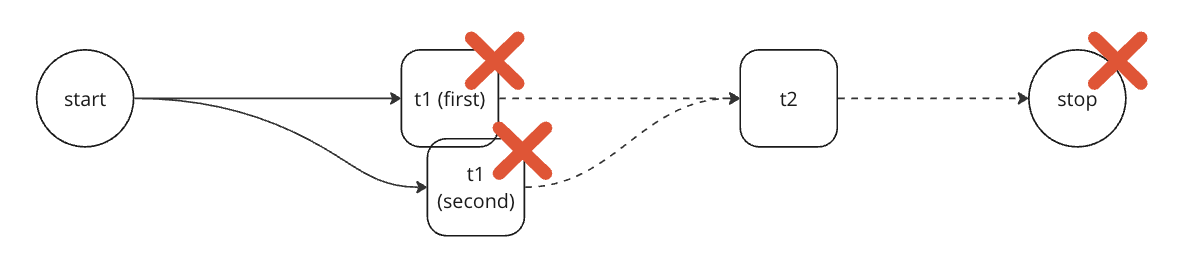

In [ ]:
from cognite.client.data_classes import TimeSeriesWrite

client.time_series.create(TimeSeriesWrite(external_id="FirstnameBirthyear-timeseries"))

## Optional tasks (onFailure)
Some tasks may not be crucial to workflow completion, for example, you could have a transformation in your ingestion pipeline that only needs to run to completion now and then, e.g., data does not often change. 

onFailure = "skipTask": when retries are exhausted, the task is marked as completed_with_errors and the workflow continues  
onFailure = "abortWorkflow": the task is marked as failed after retries are exhausted

In this example, the same Workflow will be run, but this time, the task is marked as optional.

In [55]:
client.time_series.delete(external_id="FirstnameBirthyear-timeseries", ignore_unknown_ids=True)
create_failure_version(retries=0, on_failure="skipTask")

In [ ]:
execution = workflows.executions.trigger(workflow_external_id=FirstnameBirthyear_workflow.external_id, version="failure-version")

The behaviour is now as follows:  

![title](img/optional_task_example.png)

In [ ]:
show_execution_progress(execution.id)

## Manual Cancellation and Retrying

`What can I do if a Workflow is stuck in progress?`

Workflow cancellation: stops the specified execution from starting new workflow tasks and sets the workflow execution status to TERMINATED. Already running tasks will be marked as CANCELED.

`How can I retry a Workflow when a task has failed and the underlying issue has been corrected without losing progress?`

Workflow Retry:  resumes a previously failed, timed out, or terminated workflow execution by retrying tasks that did not complete successfully. It aims to resume execution activity from the point(s) of failure.

Notes: 
- Tasks that have reached or exceeded their designated retry limits will not have their retry counts reset to zero. Instead, each retry request permits these tasks a single additional retry.
- Optional tasks that have completed_with_errors are not retried.

In this example, a workflow will be started where a task will continually fail because of a missing TimeSeries. Then the Workflow is cancelled, effectively halting the execution. Subsequently, the missing TimeSeries is created again, and the Execution is retried. Observe then that the Execution is able to complete.


In [58]:
client.time_series.delete(external_id="FirstnameBirthyear-timeseries", ignore_unknown_ids=True)
create_failure_version(retries=10, on_failure="abortWorkflow")

In [ ]:
execution = workflows.executions.trigger(workflow_external_id=FirstnameBirthyear_workflow.external_id, version="failure-version")

In [ ]:
show_execution_progress(execution.id)

In [ ]:
workflows.executions.cancel(id=execution.id, reason="Needs a coffee break")

In [ ]:
show_execution_progress(execution.id)

In [ ]:
client.time_series.create(TimeSeriesWrite(external_id="FirstnameBirthyear-timeseries"))

In [ ]:
workflows.executions.retry(id=execution.id)

In [ ]:
show_execution_progress(execution.id)

## Dynamic Tasks
`How do I execute a variable number of tasks within a workflow?`  

When a set of workflow tasks and their execution order are determined at runtime, we use dynamic tasks. It takes the tasks parameter, which should be an array of valid task definitions.

This array of tasks needs to be determined during the runtime of the workflow and can, therefore, not be included statically in the workflow definition. Instead, we can use a reference, meaning a dynamic value that will be evaluated when the workflow is executed. The dynamic value can either refer to a part of the input to the execution or the output of another task in the workflow.


![title](img/dynamic_task_example.png)

In [ ]:
def handle(client, data):
    from cognite.client.data_classes import WorkflowTask, FunctionTaskParameters
    timeseries_external_ids = data["externalIds"]

    tasks=[
        WorkflowTask(
            external_id=f"process-{ext_id}",
            parameters=FunctionTaskParameters(
                external_id="FirstnameBirthyear-function-print",
                data={"tsExtId": ext_id}
            )
        ).dump(camel_case=True)
        for ext_id in timeseries_external_ids
    ]
    
    return {"generatedTasks": tasks } 

# client.functions.delete(external_id="FirstnameBirthyear-function-dynamic")

# creating the Function may take a while.
client.functions.create(name="FirstnameBirthyear-function-dynamic", external_id="FirstnameBirthyear-function-dynamic", function_handle=handle)

In [ ]:
from cognite.client.data_classes import DynamicTaskParameters

dynamic_version = workflows.versions.upsert(version=WorkflowVersionUpsert(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version = "my-dynamic-version",
    workflow_definition=WorkflowDefinitionUpsert(
        tasks=[
            WorkflowTask(
                external_id="fetcher",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function-fetch",
                    data="${workflow.input}"
                )
            ),
            WorkflowTask(
                external_id="task-generator",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function-dynamic",
                    data="${fetcher.output.response}"
                ),
                depends_on=["fetcher"]
            ),
            WorkflowTask(
                external_id="printers",
                parameters=DynamicTaskParameters(
                    tasks="${task-generator.output.response.generatedTasks}"
                ),
                depends_on=["task-generator"]
            )
        ],
        description=None,
    )
))

visualize_workflow_version(dynamic_version)

In [ ]:
from cognite.client.data_classes import TimeSeriesWrite

client.time_series.create(
    list(TimeSeriesWrite(external_id=f"FirstnameBirthyear-{i}") for i in range(10)),
)

In [ ]:
execution = workflows.executions.trigger(workflow_external_id=FirstnameBirthyear_workflow.external_id, version=dynamic_version.version, input={"timeseries-prefix": "FirstnameBirthyear-"})

In [ ]:
show_execution_progress(execution.id)

## Async Completion ##

`What about human/async tasks?`

![title](img/asynchronous_task_completion.png)

A Cognite Function task can trigger a process running in a third-party system or prompt a user to take manual action as part of a workflow. For this type of usage, asynchronous completion of Cognite Function tasks is supported through the isAsyncComplete parameter.

When isAsyncComplete parameter is set to true, the workflow will trigger the Cognite Function, and the task status will remain IN_PROGRESS until the workflow receives an explicit callback to the update task status endpoint to change the status (to one of COMPLETED, FAILED, or FAILED_WITH_TERMINAL_ERROR).

In [ ]:
def handle(client, data):
    # a variable containing the taskId is injected into the call when isAsyncComplete is set to True
    orchestration_task_id = data["cogniteOrchestrationTaskId"]
    
    # call an external service with the callId here, the external service can then update the task when it's done!
    ...
    
    return { "taskId": orchestration_task_id }

# client.functions.delete(external_id="FirstnameBirthyear-function-async-complete")

# creating the Function may take a while.
client.functions.create(name="FirstnameBirthyear-function-async-complete", external_id="FirstnameBirthyear-function-async-complete", function_handle=handle)

In [ ]:
FirstnameBirthyear_async_completion = workflows.versions.upsert(version=WorkflowVersionUpsert(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version = "FirstnameBirthyear-async-completion",
    workflow_definition=WorkflowDefinitionUpsert(
        tasks=[
            WorkflowTask(
                external_id="async-complete-function",
                parameters=FunctionTaskParameters(
                    external_id="FirstnameBirthyear-function-async-complete",
                    is_async_complete=True
                ),
                retries=0
            )
        ],
        description=None,
    )
))

visualize_workflow_version(FirstnameBirthyear_async_completion)

In [ ]:
execution = workflows.executions.trigger(workflow_external_id=FirstnameBirthyear_workflow.external_id, version=FirstnameBirthyear_async_completion.version)

In [ ]:
show_execution_progress(execution.id)

In [ ]:
workflows.tasks.update(
    task_id='e372ed9e-ba3c-41e4-bc45-bf460d1b6d99', #copy the task id from above output and paste it here
    status="completed",
    output={"some-new-key": 1}
)

## Subworkflows
The subworkflow task type is similar to the dynamic task type, but instead of generating the array of tasks dynamically at runtime, it is included statically in the workflow definition.
 
- Use the Subworkflow task type to simplify the workflow definition significantly if you have many individual tasks that should be executed in parallel and have common upstream and downstream dependencies.
- Use the Subworkflow to mark the outcome of a collection of tasks as optional, while keeping the possibility to have required tasks within the Subworkflow

It takes the tasks parameter, which should be an array of valid task definitions.

In [93]:
from cognite.client.data_classes import SubworkflowTaskParameters

FirstnameBirthyear_async_completion = workflows.versions.upsert(version=WorkflowVersionUpsert(
    workflow_external_id=FirstnameBirthyear_workflow.external_id,
    version = "FirstnameBirthyear-async-completion",
    workflow_definition=WorkflowDefinitionUpsert(
        tasks=[
            WorkflowTask(
                external_id="subworkflow",
                parameters=SubworkflowTaskParameters(
                    tasks=[
                        WorkflowTask(
                            external_id="async-complete-function",
                            parameters=FunctionTaskParameters(
                                external_id="FirstnameBirthyear-function-async-complete",
                            ),
                            retries=0
                        )
                    ]
                ),
                retries=0
            )
        ],
        description=None,
    )
))

## Scheduling Workflows ##
Currently, workflows do not support scheduled triggers. Use a Cognite Function (with schedules) to schedule workflows effectively; see the following example for reference.

#### Step 1. Create the Cognite Function that will act as the workflow trigger
You need to specify the client_credentials parameter inside the call to client.workflows.executions.trigger for the authentication to work at runtime.

In [ ]:
# Define Function handle
def handle(client, data, secrets):
    from cognite.client.data_classes import ClientCredentials

    execution = client.workflows.executions.trigger(
        workflow_external_id=data["workflow-external-id"],
        version=data["workflow-version"],
    )

    return f"Workflow execution ID: {execution.id}"

# Create the Function
function_name = "FirstnameBirthyear-workflow_trigger"
client.functions.create(
    name=function_name,
    external_id=function_name,
    function_handle=handle,
)

#### Step 2: Create a Cognite Function schedule for each scheduled workflow trigger you need

In [101]:
from cognite.client.data_classes import ClientCredentials

# Enter a cron expression for the schedule
cron_expression = "* * * * *"  # E.g. every minute. Use https://crontab.guru/ to create a valid expression
# Enter the details of the workflow to schedule
workflow_external_id = FirstnameBirthyear_workflow.external_id
workflow_version = workflow_with_all_task_types.version

function_id = client.functions.retrieve(external_id=function_name).id
schedule = client.functions.schedules.create(
    name=f"Scheduled trigger: {workflow_external_id}",
    cron_expression=cron_expression,
    function_id=function_id,
    data={
        "workflow-external-id": workflow_external_id,
        "workflow-version": workflow_version,
    },
)

In [102]:
client.functions.schedules.delete(id=schedule.id)

## Thanks for learning with us!

### Clean up
Run the cell below to clean up all of the resources created during the showcase.

In [ ]:
workflows.delete(external_id="FirstnameBirthyear-workflow", ignore_unknown_ids=True)

client.transformations.delete(external_id="FirstnameBirthyear-transform", ignore_unknown_ids=True)

client.functions.delete(external_id="FirstnameBirthyear-function-fetch")
client.functions.delete(external_id="FirstnameBirthyear-function-print")
client.functions.delete(external_id="FirstnameBirthyear-function-dynamic")
client.functions.delete(external_id="FirstnameBirthyear-function-async-complete")
client.functions.delete(external_id="FirstnameBirthyear-workflow_trigger")

client.time_series.delete(external_id="FirstnameBirthyear-timeseries", ignore_unknown_ids=True)
client.time_series.delete(
    external_id=[f"FirstnameBirthyear-{i}" for i in range(10)], ignore_unknown_ids=True
)